## _Random Forest_

In [1]:
#Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import model_evaluation_utils as meu

from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.preprocessing import label_binarize
from mlxtend.plotting import plot_decision_regions

#Just in Case
import warnings
warnings.filterwarnings('ignore')

import h2o

### _Contactabilidad_

In [3]:
#Establecer nuestro directorio de trabajo
os.chdir('D:\Social Data Consulting\DataPESADA')

In [4]:
#Importando nuestro archivo de trabajo
mitrain="data_selec_entre.csv"
dataCSV=pd.read_csv(mitrain)
dataCSV.head()

,NUMPRIORIZACION,NC_DISTR12,TOTGEST6,TOTGEST12,IDGRUPO,DIAS_ACT,FBK_ULT6,FBK_ULT12,FBK_BEST6,DIAS_BEST6,...,NT_CTD6,NT_DISTR6,NT_DIAS6,PROVINCIA,DEPARTAMENTO,INGRESO_NETO_VIGENTE,INGRESO_BRUTO,SEGMENTO,RANGO_INGRESOS,TARGET
0,1,0.333333,6,6,3,118,TLV,TLV,TLV,8,...,-999,-999.0,-999,TACNA,TACNA,7136,9389,2,Entre S/.4000-10000,1
1,1,0.461538,13,13,40,94,TLV,TLV,TLV,46,...,-999,-999.0,-999,LIMA,LIMA,6920,9105,1BC,Entre S/.4000-10000,1
2,1,0.666667,2,6,6,223,TLV,TLV,TLV,127,...,-999,-999.0,-999,LIMA,LIMA,1473,1655,2,Entre S/.1000-4000,1
3,1,-999.000000,4,4,95,96,TLV,TLV,TLV,49,...,-999,-999.0,-999,LIMA,LIMA,2293,2729,2,Entre S/.1000-4000,1
4,1,0.187500,10,16,4,91,TLV,TLV,TLV,27,...,-999,-999.0,-999,CUSCO,CUSCO,6470,8513,3,Entre S/.4000-10000,1


In [5]:
#Recodificando nuestra variable TARGET
dataCSV.TARGET=dataCSV.TARGET.replace(1,"si")
dataCSV.TARGET=dataCSV.TARGET.replace(0,"no")

In [6]:
#Dimensiones del dataframe de entrenanmiento
dataCSV.shape

(757391, 40)

In [7]:
#Identificando los nombres de columnas, predictores y target
colnames=dataCSV.columns.to_list()
predictores=colnames[0:len(colnames)-1]
target=colnames[len(colnames)-1]
print(predictores)
print(target)

['NUMPRIORIZACION', 'NC_DISTR12', 'TOTGEST6', 'TOTGEST12', 'IDGRUPO', 'DIAS_ACT', 'FBK_ULT6', 'FBK_ULT12', 'FBK_BEST6', 'DIAS_BEST6', 'DIAS_ULT6', 'FBK_BEST12', 'DIAS_BEST12', 'DIAS_ULT12', 'CNE_CTD12', 'CNE_CTD6', 'CNE_DIAS6', 'CNE_DISTR6', 'CNE_DISTR12', 'CNE_DIAS12', 'NC_CTD12', 'NC_DIAS6', 'NC_DIAS12', 'NC_CTD6', 'RECENCIA_APP', 'COD_SALA', 'NT_CTD12', 'NT_DISTR12', 'NT_DIAS12', 'FEC_LLAMADA', 'NT_CTD6', 'NT_DISTR6', 'NT_DIAS6', 'PROVINCIA', 'DEPARTAMENTO', 'INGRESO_NETO_VIGENTE', 'INGRESO_BRUTO', 'SEGMENTO', 'RANGO_INGRESOS']
TARGET


### _Inicializando h2o_

In [9]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,22 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,3 months and 28 days !!!
H2O_cluster_name:,H2O_from_python_Diego_LeÃ³n_2smt9o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.973 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### _Random Forest con H2O_

In [10]:
#Convirtiendo nuestro DF Pandas a un objeto H2OFrame
datah2o_train=h2o.H2OFrame(dataCSV)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [11]:
type(datah2o_train)

h2o.frame.H2OFrame

In [12]:
#Instanciamos un objeto de clase H2ORandomForestEstimator
m=h2o.estimators.H2ORandomForestEstimator(nfolds=10, #particiones para CV
                                          max_depth=3, #maxima profundidad
                                          ntrees=100, #número de arboles
                                          seed=2020) #semilla

In [13]:
#Hacer que el modelo aprenda de los datos
m.train(x=predictores,
       y=target,
       training_frame=datah2o_train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


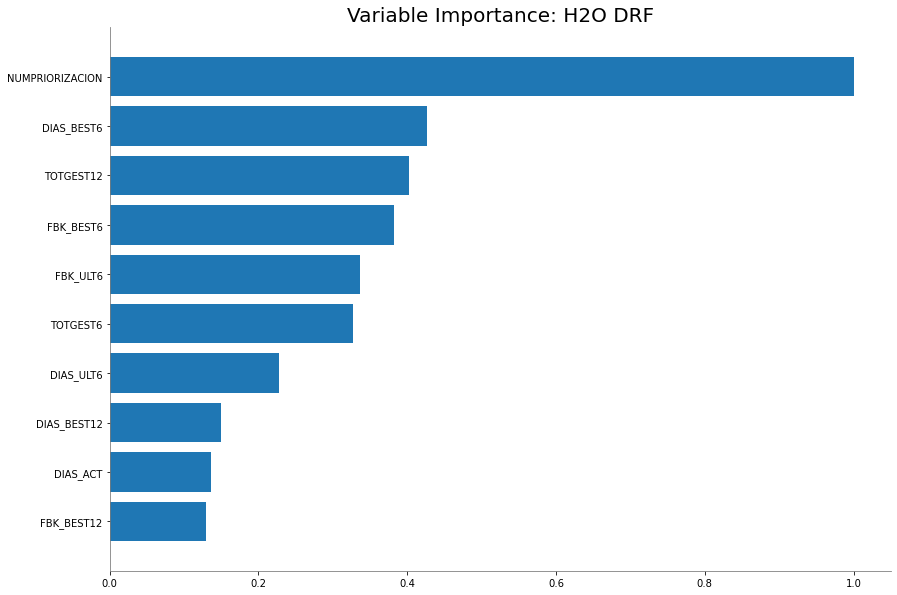

In [14]:
#Identificando a las variables más importantes para Random Forest
m.varimp_plot()

In [15]:
#Evaluar la performance del modelo con los datos de entrenamiento
performance_train= m.model_performance(datah2o_train)
performance_train


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.17148151978228446
RMSE: 0.4141032718806801
LogLoss: 0.5209345518316323
Mean Per-Class Error: 0.26000608879896525
AUC: 0.7980377648641939
AUCPR: 0.8614898690996347
Gini: 0.5960755297283877

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4178539842762007: 


,,no,si,Error,Rate
0,no,98806.0,166194.0,0.6271,(166194.0/265000.0)
1,si,29221.0,463170.0,0.0593,(29221.0/492391.0)
2,Total,128027.0,629364.0,0.258,(195415.0/757391.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.417854,0.825795,303.0
1,max f2,0.315028,0.908525,357.0
2,max f0point5,0.709587,0.818902,136.0
3,max accuracy,0.571447,0.764032,218.0
4,max precision,0.857264,1.000000,0.0
5,max recall,0.235301,1.000000,399.0
6,max specificity,0.857264,1.000000,0.0
7,max absolute_mcc,0.601236,0.473702,201.0
8,max min_per_class_accuracy,0.685256,0.735075,154.0
9,max mean_per_class_accuracy,0.709587,0.739994,136.0



Gains/Lift Table: Avg response rate: 65.01 %, avg score: 65.01 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010009,0.854579,1.455610,1.455610,0.946313,0.855474,0.946313,0.855474,0.014570,0.014570,45.560959,45.560959,0.013034
1,2,0.020099,0.853904,1.461502,1.458568,0.950144,0.854204,0.948236,0.854837,0.014746,0.029316,46.150208,45.856764,0.026343
2,3,0.030465,0.853313,1.427298,1.447928,0.927907,0.853551,0.941319,0.854399,0.014795,0.044111,42.729785,44.792800,0.039002
3,4,0.040315,0.852731,1.445198,1.447261,0.939544,0.852973,0.940886,0.854051,0.014235,0.058346,44.519772,44.726094,0.051535
4,5,0.050007,0.852263,1.431328,1.444173,0.930527,0.852482,0.938878,0.853747,0.013873,0.072219,43.132776,44.417275,0.063483
5,6,0.100013,0.850698,1.411355,1.427764,0.917542,0.851403,0.928210,0.852575,0.070576,0.142795,41.135467,42.776393,0.122274
6,7,0.150004,0.846456,1.365371,1.406970,0.887648,0.849389,0.914692,0.851513,0.068257,0.211052,36.537078,40.697042,0.174478
7,8,0.200042,0.833366,1.326932,1.386950,0.862658,0.839490,0.901676,0.848506,0.066396,0.277448,32.693154,38.694987,0.221233
8,9,0.300006,0.791970,1.282286,1.352075,0.833633,0.817519,0.879004,0.838181,0.128183,0.405631,28.228565,35.207500,0.301884
9,10,0.400298,0.765873,1.312403,1.342135,0.853212,0.775181,0.872542,0.822397,0.131623,0.537254,31.240265,34.213539,0.391431


In [16]:
#Podemos obtener la matriz de confusión para los Datos de Entrenamiento
performance_train.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4178539842762007: 


,,no,si,Error,Rate
0,no,98806.0,166194.0,0.6271,(166194.0/265000.0)
1,si,29221.0,463170.0,0.0593,(29221.0/492391.0)
2,Total,128027.0,629364.0,0.258,(195415.0/757391.0)


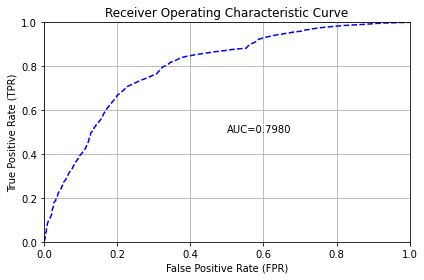

In [17]:
#Podemos obtener la curva ROC y AUC para los Datos de Entrenamiento
performance_train.plot('roc')

### _Testing del Modelo_

In [18]:
mitest="data_selec_test.csv"
dataCSV2=pd.read_csv(mitest)
dataCSV2.head()

,NUMPRIORIZACION,NC_DISTR12,TOTGEST6,TOTGEST12,IDGRUPO,DIAS_ACT,FBK_ULT6,FBK_ULT12,FBK_BEST6,DIAS_BEST6,...,NT_CTD6,NT_DISTR6,NT_DIAS6,PROVINCIA,DEPARTAMENTO,INGRESO_NETO_VIGENTE,INGRESO_BRUTO,SEGMENTO,RANGO_INGRESOS,TARGET
0,1,0.5,-999,2,4,85,NULO,TLV,NULO,-999,...,-999,-999.0,-999,CORONEL PORTILLO,UCAYALI,2664,3171,2,Entre S/.1000-4000,0
1,2,-999.0,-999,-999,79,34,NULO,NULO,NULO,-999,...,-999,-999.0,-999,CORONEL PORTILLO,UCAYALI,2663,3170,2,Entre S/.1000-4000,0
2,1,-999.0,-999,-999,95,62,NULO,NULO,NULO,-999,...,-999,-999.0,-999,CORONEL PORTILLO,UCAYALI,4421,5596,1BC,Entre S/.4000-10000,0
3,1,0.8,5,5,95,98,TLV,TLV,TLV,127,...,-999,-999.0,-999,CORONEL PORTILLO,UCAYALI,2325,2767,3,Entre S/.1000-4000,0
4,1,0.4,5,5,4,8,TLV,TLV,TLV,50,...,-999,-999.0,-999,CORONEL PORTILLO,UCAYALI,1233,1385,2,Entre S/.1000-4000,0


In [25]:
#Recodificando nuestra variable TARGET
dataCSV2.TARGET=dataCSV2.TARGET.replace(1,"si")
dataCSV2.TARGET=dataCSV2.TARGET.replace(0,"no")

In [26]:
#Transformar nustro DF de pandas a un objeto H20Frame
#Convirtiendo nuestro DF Pandas a un objeto H2OFrame
datah2o_test=h2o.H2OFrame(dataCSV2)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
type(datah2o_test)

h2o.frame.H2OFrame

In [28]:
#Evaluar la performance del modelo con los datos de entrenamiento
performance_test= m.model_performance(datah2o_test)
performance_test


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.25706539082140284
RMSE: 0.5070161642604729
LogLoss: 0.7068153083751597
Mean Per-Class Error: 0.49797984525055683
AUC: 0.4835712896249387
AUCPR: 0.8932051543959671
Gini: -0.032857420750122546

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23962575776931494: 


,,no,si,Error,Rate
0,no,0.0,55823.0,1.0,(55823.0/55823.0)
1,si,0.0,492391.0,0.0,(0.0/492391.0)
2,Total,0.0,548214.0,0.1018,(55823.0/548214.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.239626,0.946355,399.0
1,max f2,0.239626,0.977828,399.0
2,max f0point5,0.239626,0.916845,399.0
3,max accuracy,0.239626,0.898173,399.0
4,max precision,0.854455,0.898655,2.0
5,max recall,0.239626,1.000000,399.0
6,max specificity,0.856459,0.998854,0.0
7,max absolute_mcc,0.753267,0.023748,88.0
8,max min_per_class_accuracy,0.560457,0.485253,211.0
9,max mean_per_class_accuracy,0.314921,0.502020,355.0



Gains/Lift Table: Avg response rate: 89.82 %, avg score: 55.27 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.853693,0.964759,0.964759,0.866521,0.854771,0.866521,0.854771,0.009651,0.009651,-3.524064,-3.524064,-0.003462
1,2,0.020016,0.852483,0.980513,0.972640,0.880670,0.853093,0.873599,0.853932,0.009817,0.019468,-1.948683,-2.736014,-0.005378
2,3,0.030339,0.851686,0.994538,0.980091,0.893267,0.852032,0.880291,0.853285,0.010266,0.029734,-0.546177,-1.990927,-0.005932
3,4,0.040145,0.851075,0.991182,0.982800,0.890253,0.851310,0.882724,0.852803,0.009720,0.039454,-0.881790,-1.719993,-0.006781
4,5,0.050187,0.850348,1.011641,0.988571,0.908629,0.850682,0.887908,0.852378,0.010159,0.049613,1.164090,-1.142925,-0.005633
5,6,0.100003,0.833355,0.994451,0.991500,0.893189,0.842740,0.890539,0.847577,0.049540,0.099153,-0.554867,-0.849985,-0.008348
6,7,0.150013,0.808716,1.000312,0.994438,0.898453,0.824715,0.893177,0.839956,0.050025,0.149178,0.031228,-0.556215,-0.008194
7,8,0.200148,0.775697,0.962275,0.986381,0.864290,0.789018,0.885941,0.827196,0.048244,0.197422,-3.772476,-1.361863,-0.026768
8,9,0.300000,0.730802,0.993492,0.988748,0.892327,0.756478,0.888067,0.803658,0.099202,0.296624,-0.650833,-1.125205,-0.033150
9,10,0.400037,0.658337,1.004150,0.992599,0.901900,0.699333,0.891526,0.777570,0.100453,0.397077,0.414957,-0.740056,-0.029074


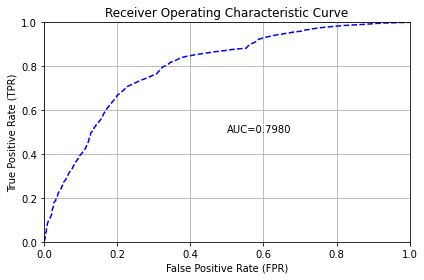

In [29]:
#Podemos obtener la curva ROC y AUC para los Datos de Entrenamiento
performance_train.plot('roc')

### Hallando las probabilidades de YPredicho

In [30]:
#Calculando las probabilidades de la prediccion target para los datos de entrenamiento
ypredicho_train=m.predict(datah2o_train)
ypredicho_train

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,no,si
si,0.150791,0.849209
si,0.148854,0.851146
si,0.255612,0.744388
si,0.198355,0.801645
si,0.14593,0.85407
si,0.238608,0.761392
si,0.151162,0.848838
si,0.145895,0.854105
no,0.752958,0.247042
si,0.220573,0.779427


In [31]:
type(ypredicho_train)

h2o.frame.H2OFrame

In [33]:
#Convertir un objeto H20Frame en un DataFrame de Pandas
ypredicho_train_pandas=h2o.as_list(ypredicho_train)
ypredicho_train_pandas

,predict,no,si
0,si,0.150791,0.849209
1,si,0.148854,0.851146
2,si,0.255612,0.744388
3,si,0.198355,0.801645
4,si,0.145930,0.854070
...,...,...,...
757386,si,0.460429,0.539571
757387,si,0.559274,0.440726
757388,si,0.432012,0.567988
757389,si,0.532266,0.467734


In [34]:
print(type(ypredicho_train_pandas))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
## Con test

In [35]:
#Calculando las probabilidades de la prediccion target para los datos de entrenamiento
ypredicho_test=m.predict(datah2o_test)
ypredicho_test

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,no,si
si,0.375729,0.624271
no,0.687411,0.312589
no,0.593346,0.406654
si,0.235294,0.764706
si,0.166958,0.833042
si,0.156974,0.843026
no,0.648308,0.351692
no,0.616123,0.383877
no,0.616123,0.383877
no,0.692436,0.307564


In [36]:
#Convertir un objeto H20Frame en un DataFrame de Pandas
ypredicho_test_pandas=h2o.as_list(ypredicho_test)
ypredicho_test_pandas

,predict,no,si
0,si,0.375729,0.624271
1,no,0.687411,0.312589
2,no,0.593346,0.406654
3,si,0.235294,0.764706
4,si,0.166958,0.833042
...,...,...,...
548209,no,0.601533,0.398467
548210,no,0.588052,0.411948
548211,si,0.561020,0.438980
548212,no,0.679841,0.320159


#### Optimizando Parámetros (Ejemplo: Profundidad del Árbol)

In [ ]:
for i in range(2,6):
    m=h2o.estimators.H2ORandomForestEstimator(nfolds=10, #particiones para CV
                                          max_depth=i, #maxima profundidad
                                          ntrees=100, #número de arboles
                                          seed=2020) #semilla
    m.train(x=predictores, y=target,training_frame=datah2o_train)
    performance= m.model_performance(datah2o_train)
    auc=performance.auc()
    print('Para max_depth ',i,'se tiene un AUC de',auc)

### _CASO VINO ROJO Y BLANCO_

In [39]:
os.chdir('D:\Social Data Consulting\Python for Data Science\data')

In [52]:
# Importando los archivos de trabajo necesarios
miblanco="winequality-white.csv"
mirojo="winequality-red.csv"
white_wine=pd.read_csv(miblanco,sep=";")
red_wine=pd.read_csv(mirojo,sep=";")

In [53]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [54]:
#Agregar una columna identificadora o descriptora de cada tipo de vino
white_wine["wine_type"]='white'
red_wine["wine_type"]='red'

#Concatenando los dataframes
wines=pd.concat([white_wine,red_wine])
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [55]:
#Creando una variable categorica que discretiz la variable quality
wines['quality_label']=wines['quality'].apply(lambda value:'low' if value <=5 else 'medium' if value <=7 else 'high')
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,medium
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,medium
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,medium
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,medium


In [56]:
wines=wines.sample(frac=1,random_state=42).reset_index(drop=True)
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,7.0,0.25,0.45,2.3,0.045,40.0,118.0,0.99064,3.16,0.48,11.9,7,white,medium
1,7.6,0.14,0.74,1.6,0.040,27.0,103.0,0.99160,3.07,0.40,10.8,7,white,medium
2,6.2,0.15,0.27,11.0,0.035,46.0,116.0,0.99602,3.12,0.38,9.1,6,white,medium
3,6.7,0.16,0.32,12.5,0.035,18.0,156.0,0.99666,2.88,0.36,9.0,6,white,medium
4,6.8,0.27,0.22,17.8,0.034,16.0,116.0,0.99890,3.07,0.53,9.2,5,white,low


In [57]:
#Visualizando la cantidad de registros
print(len(white_wine))
print(len(red_wine))
print(len(wines))

4898
1599
6497


In [58]:
#Almancenado los nombres de las etiquetas de la target
class_wines=np.array(wines.quality_label)
class_wines

array(['medium', 'medium', 'medium', ..., 'medium', 'medium', 'high'],
      dtype=object)

In [59]:
#Almacenando las etiquetas de mi target
class_wines_label=['low','medium','high']
class_wines_label

['low', 'medium', 'high']

In [60]:
#Refresh de la data
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,7.0,0.25,0.45,2.3,0.045,40.0,118.0,0.99064,3.16,0.48,11.9,7,white,medium
1,7.6,0.14,0.74,1.6,0.040,27.0,103.0,0.99160,3.07,0.40,10.8,7,white,medium
2,6.2,0.15,0.27,11.0,0.035,46.0,116.0,0.99602,3.12,0.38,9.1,6,white,medium
3,6.7,0.16,0.32,12.5,0.035,18.0,156.0,0.99666,2.88,0.36,9.0,6,white,medium
4,6.8,0.27,0.22,17.8,0.034,16.0,116.0,0.99890,3.07,0.53,9.2,5,white,low


In [61]:
predictores=wines.iloc[:,:-3]
predictores.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.25,0.45,2.3,0.045,40.0,118.0,0.99064,3.16,0.48,11.9
1,7.6,0.14,0.74,1.6,0.040,27.0,103.0,0.99160,3.07,0.40,10.8
2,6.2,0.15,0.27,11.0,0.035,46.0,116.0,0.99602,3.12,0.38,9.1
3,6.7,0.16,0.32,12.5,0.035,18.0,156.0,0.99666,2.88,0.36,9.0
4,6.8,0.27,0.22,17.8,0.034,16.0,116.0,0.99890,3.07,0.53,9.2


In [62]:
predictores_names=list(predictores.columns)
print(predictores_names)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


#### Particionamiento de los Datos

In [63]:
xtrain,xtest,ytrain,ytest=train_test_split(predictores,class_wines,test_size=0.3,random_state=2020)

#### Modelando mediante Arboles de Decision

In [64]:
#Instanciamos un objeto de clase DecisionTreeClassifier
modelo=DecisionTreeClassifier(criterion='entropy',
                             min_samples_split=100,
                             max_depth=4,
                             random_state=2020)

### _Validación Cruzada_

In [66]:
scores=cross_val_score(modelo,
                      xtrain,
                      ytrain,
                      scoring='accuracy',
                      cv=30)
scores

array([0.69736842, 0.70394737, 0.72368421, 0.71052632, 0.67763158,
       0.73684211, 0.65131579, 0.72368421, 0.70394737, 0.66447368,
       0.69078947, 0.71052632, 0.69736842, 0.69078947, 0.71052632,
       0.72368421, 0.72368421, 0.64238411, 0.74172185, 0.70860927,
       0.65562914, 0.75496689, 0.74172185, 0.70860927, 0.75496689,
       0.71523179, 0.74834437, 0.70860927, 0.67549669, 0.69536424])

In [67]:
#Score Promedio
scores.mean()

0.7064148367607762

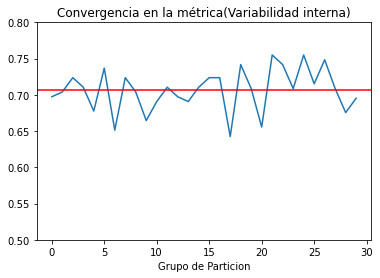

In [71]:
#Analizando visualmente la estabilidad de la métrica
plt.plot(range(0,30),scores)
plt.ylim([0.5,0.8])
plt.axhline(y=scores.mean(),color='red')
plt.xlabel('Grupo de Particion')
plt.title('Convergencia en la métrica(Variabilidad interna)')
plt.show()

In [72]:
#Aprendiendo de los datos
modelo.fit(xtrain,ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=100,
                       random_state=2020)

In [73]:
#Calculando los valores predichos (Data de Entrenamiento)
ypredicho_train=modelo.predict(xtrain)

In [74]:
#Evaluando las principales metricas para la Data de Entrenamiento
meu.display_model_performance_metrics(true_labels=ytrain,
                                     predicted_labels=ypredicho_train,
                                     classes=class_wines_label)

Model Performance metrics:
------------------------------
Accuracy: 0.7192
Precision: 0.7301
Recall: 0.7192
F1 Score: 0.7099

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.64      0.70      0.67      1672
      medium       0.77      0.76      0.77      2742
        high       1.00      0.01      0.01       133

    accuracy                           0.72      4547
   macro avg       0.80      0.49      0.48      4547
weighted avg       0.73      0.72      0.71      4547


Prediction Confusion Matrix:
------------------------------
         low  medium  high
low     1175     497     0
medium   648    2094     0
high       3     129     1


In [81]:
#Calculando los valores predichos (Data de Entrenamiento)
ypredicho_test=modelo.predict(xtest)

In [82]:
#Evaluando las principales metricas para la Data de Entrenamiento
meu.display_model_performance_metrics(true_labels=ytest,
                                     predicted_labels=ypredicho_test,
                                     classes=class_wines_label)

Model Performance metrics:
------------------------------
Accuracy: 0.7062
Precision: 0.6867
Recall: 0.7062
F1 Score: 0.6958

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.63      0.70      0.66       712
      medium       0.76      0.75      0.75      1173
        high       0.00      0.00      0.00        65

    accuracy                           0.71      1950
   macro avg       0.46      0.48      0.47      1950
weighted avg       0.69      0.71      0.70      1950


Prediction Confusion Matrix:
------------------------------
        low  medium  high
low     497     215     0
medium  291     880     2
high      1      64     0


### _Modelando mediante Random Forest_

In [75]:
#Instanciando un objeto de clase RandomForestClassifier
modelo_rf=RandomForestClassifier(n_estimators=100,
                                bootstrap=True,
                                criterion='entropy',
                                random_state=2020)

In [76]:
#Aprendiendo de los datos
modelo_rf.fit(xtrain,ytrain)

RandomForestClassifier(criterion='entropy', random_state=2020)

In [77]:
#Calcular los valores predichos para la data de entrenamiento
ypredicho_train_rf=modelo_rf.predict(xtrain)

In [78]:
#Evaluando las principales metricas para la Data de Entrenamiento
meu.display_model_performance_metrics(true_labels=ytrain,
                                     predicted_labels=ypredicho_train_rf,
                                     classes=class_wines_label)

Model Performance metrics:
------------------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       1.00      1.00      1.00      1672
      medium       1.00      1.00      1.00      2742
        high       1.00      1.00      1.00       133

    accuracy                           1.00      4547
   macro avg       1.00      1.00      1.00      4547
weighted avg       1.00      1.00      1.00      4547


Prediction Confusion Matrix:
------------------------------
         low  medium  high
low     1672       0     0
medium     0    2742     0
high       0       0   133


### TESTING

In [79]:
#Calcular los valores predichos para la data de entrenamiento
ypredicho_test_rf=modelo_rf.predict(xtest)

In [80]:
#Evaluando las principales metricas para la Data de Entrenamiento
meu.display_model_performance_metrics(true_labels=ytest,
                                     predicted_labels=ypredicho_test_rf,
                                     classes=class_wines_label)

Model Performance metrics:
------------------------------
Accuracy: 0.8103
Precision: 0.8145
Recall: 0.8103
F1 Score: 0.8032

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.79      0.75      0.77       712
      medium       0.82      0.88      0.85      1173
        high       1.00      0.22      0.35        65

    accuracy                           0.81      1950
   macro avg       0.87      0.62      0.66      1950
weighted avg       0.81      0.81      0.80      1950


Prediction Confusion Matrix:
------------------------------
        low  medium  high
low     537     175     0
medium  144    1029     0
high      0      51    14


### Tunning de Parámetros, ajuste de parámetros

In [83]:
#Imprimiendo los argumentos actuales de los parámetros actuales de mi modelo
print(modelo_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2020, 'verbose': 0, 'warm_start': False}


In [84]:
#help(GridSearchCV)

In [85]:
#param_grid como diccionario
param_grid={'n_estimators':[100,200,300,400,500],
           'max_features':['auto',None,'log2']}

#Instanciamos un objeto de la clase GridSearchCV
tunning=GridSearchCV(modelo_rf,param_grid,cv=10,scoring='accuracy')

#Hacer aprender de los datos
tunning.fit(xtrain,ytrain)

#Visualizar la mejor combinación de los valores de los parametros
print(tunning.best_params_)

{'max_features': 'auto', 'n_estimators': 400}


In [87]:
tunning.cv_results_

{'mean_fit_time': array([ 0.91590743,  1.92746727,  4.37178671,  6.97872136,  8.42766774,
         6.14815555,  8.30850441, 11.02588935, 12.49177375, 15.16060233,
         1.15463674,  2.08964567,  3.16712208,  4.08971038,  5.35828733]),
 'std_fit_time': array([0.01972276, 0.15516389, 0.62160754, 1.16490353, 1.90517862,
        1.59817554, 2.47017036, 1.56482545, 0.92574459, 1.20419148,
        0.11989989, 0.03519767, 0.1377808 , 0.17566078, 0.47869758]),
 'mean_score_time': array([0.01911211, 0.0388593 , 0.08725262, 0.1300719 , 0.18094747,
        0.05101349, 0.05600605, 0.08309624, 0.09146619, 0.10116444,
        0.02436895, 0.03961844, 0.05917857, 0.07280071, 0.09989274]),
 'std_score_time': array([0.00186042, 0.00784101, 0.02076117, 0.0323576 , 0.05336638,
        0.0160548 , 0.023914  , 0.02782851, 0.0164668 , 0.01343804,
        0.00426112, 0.00186665, 0.00359367, 0.00259126, 0.01730902]),
 'param_max_features': masked_array(data=['auto', 'auto', 'auto', 'auto', 'auto', None, Non

In [88]:
#Mostrando las iteraciones de los valores de los parámetros
resultados=tunning.cv_results_
for param, score_mean, score_sd in zip(resultados['params'],resultados['mean_test_score'],resultados['std_test_score']):
    print(param,score_mean,score_sd)

{'max_features': 'auto', 'n_estimators': 100} 0.7974459021155057 0.014641100584981557
{'max_features': 'auto', 'n_estimators': 200} 0.7985452873118071 0.014534025100095146
{'max_features': 'auto', 'n_estimators': 300} 0.7978854625550661 0.015036912137970702
{'max_features': 'auto', 'n_estimators': 400} 0.7992055961659486 0.01723584880120912
{'max_features': 'auto', 'n_estimators': 500} 0.7978854625550661 0.015294802796679998
{'max_features': None, 'n_estimators': 100} 0.7893101612044343 0.016839668134403376
{'max_features': None, 'n_estimators': 200} 0.7906302948153169 0.015862878508658047
{'max_features': None, 'n_estimators': 300} 0.7906293266205161 0.018496541694392885
{'max_features': None, 'n_estimators': 400} 0.7906298107179165 0.018389246707685963
{'max_features': None, 'n_estimators': 500} 0.7908486227428959 0.01880697356828838
{'max_features': 'log2', 'n_estimators': 100} 0.7974459021155057 0.014641100584981557
{'max_features': 'log2', 'n_estimators': 200} 0.7985452873118071 0